# Multiclass Classification (5/6)

In this notebook, after importing the necessary data and defining the class weights, we perform the following process in search of our model for the multiclass problem:
1) Find an underfitting and an overfitting model.
2) Do a grid search testing the parameters between the boundaries of the underfitting and overfitting model.
3) Perform cross validation on the model found.
4) Try some pretrained models, do transfer learning and fine-tuning.
5) Try some changes in the loss function, inputs and images to improve the results.
6) Evaluate our best model on the test set.


## Imports

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#model selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

#preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L1L2

#dl libraraies
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalFocalCrossentropy

from keras.layers import Dense
from keras.optimizers import Adam,Adagrad,Adadelta,RMSprop

# specifically for cnn
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, concatenate, Input

import tensorflow as tf
import kerastuner as kt

# tools
import os
%load_ext autoreload
%autoreload 2
from utils.tools import evaluate_model_train, evaluate_model_predictions, reg_wrapper, opt_wrapper

# pre-trained model
from tensorflow.keras.applications import (
    ResNet50,
    InceptionV3,
    DenseNet121,
    VGG16,
    Xception,
    VGG19,
    ResNet50V2,
    ResNet101,
    ResNet101V2,
    ResNet152V2,
    InceptionResNetV2,
    MobileNet,
    MobileNetV2,
    DenseNet121,
    DenseNet169,
    DenseNet201,
    NASNetMobile,
    NASNetLarge,
    EfficientNetB0,
    EfficientNetB1,
    EfficientNetB2,
    EfficientNetB3,
    EfficientNetB4,
    EfficientNetB5,
    EfficientNetB6,
    EfficientNetV2B0
    )

In [2]:
os.getcwd()

'c:\\Users\\luisb\\OneDrive\\Documentos\\uni\\Year 3\\Semester 1\\Deep learning\\project\\DL_project\\Notebooks'

## Data

In [2]:
%cd ..

# labels
with open('./Data_Images/Ylabels_Bi_MC.pkl', 'rb') as file:  
    _, y_labels = pickle.load(file)

# train
with open('./Data_Images/Train_HP_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_train_hp_a, _, y_multiclass_train_hp, Mag_train_hp = pickle.load(file)

# validaton
with open('./Data_Images/Val_HP_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_val_hp_a, _, y_multiclass_val_hp, Mag_val_hp = pickle.load(file)

# test
with open('./Data_Images/Test_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_test_a, _, y_multiclass_test, Mag_test = pickle.load(file)

# CV
with open('./Data_Images/Train_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_train_a, _, y_multiclass_train, Mag_train = pickle.load(file)

# label encoder
with open('./Data_Images/LabelEncoder_Bi_MC.pkl', 'rb') as file:  
     _, label_encoder_multiclass= pickle.load(file)

c:\Users\saral\Desktop\3_year_1_semester\Deep learning\Project\DL_project


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = {key:val for key, val in zip(label_encoder_multiclass.transform(np.unique(y_labels)),class_weights)}
class_weights_dict

{np.int64(0): np.float64(2.2266328828828827),
 np.int64(1): np.float64(0.2864749348015068),
 np.int64(2): np.float64(0.9749753451676528),
 np.int64(3): np.float64(1.579273162939297),
 np.int64(4): np.float64(1.2482638888888888),
 np.int64(5): np.float64(1.7654017857142856),
 np.int64(6): np.float64(2.1823951434878586),
 np.int64(7): np.float64(1.7374780316344465)}

In [4]:
shape_input = X_train_hp_a.shape[1:]
shape_input

(150, 150, 3)

In [5]:
shape_mag = Mag_train_hp.shape[1:]
shape_mag

(4,)

## Multiclass Classification

In [8]:
# for optaining identical results each time we run the notebooks
tf.random.set_seed(23)

### Base Model Underfitting


In [ ]:
model_MC_BMU = Sequential()
model_MC_BMU.add(Conv2D(32, (5,5), activation='relu', input_shape=shape_input))
model_MC_BMU.add(Conv2D(32, (5,5), activation='relu'))
model_MC_BMU.add(MaxPooling2D((5,5)))
model_MC_BMU.add(Flatten())
model_MC_BMU.add(Dense(128, activation='relu'))

model_MC_BMU.add(Dense(8, activation='softmax'))
model_MC_BMU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])
model_MC_BMU.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 146, 146, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 142, 142, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,240,488 (12.36 MB)

 Trainable params: 3,240,488 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_MC_BMU = model_MC_BMU.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 100, epochs=3, callbacks=list_callbacks, 
                                  validation_data=[X_val_hp_a, y_multiclass_val_hp], class_weight=class_weights_dict)

Epoch 1/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - F1Score: 0.1085 - loss: 2.4862 - val_F1Score: 0.0580 - val_loss: 2.2187 - learning_rate: 0.0010
Epoch 2/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - F1Score: 0.1287 - loss: 2.0804 - val_F1Score: 0.1482 - val_loss: 1.8594 - learning_rate: 0.0010
Epoch 3/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - F1Score: 0.1994 - loss: 1.9597 - val_F1Score: 0.2260 - val_loss: 1.7044 - learning_rate: 0.0010


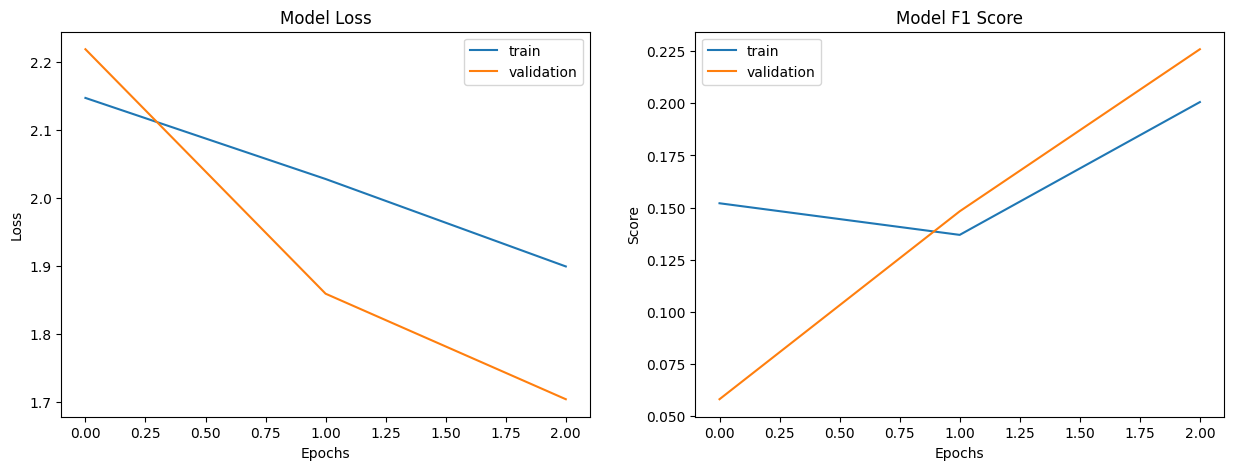

In [ ]:
evaluate_model_train(history_MC_BMU)

This model is obviously underfitting since the scores on the validation data are better than in the train one. This also tells us that we will need to train our model for more epochs since the scores at the begging are very low and are not in a flat trend at the end. 

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
                     precision    recall  f1-score   support

           adenosis       0.26      0.07      0.11        71
   ductal_carcinoma       0.69      0.40      0.51       553
       fibroadenoma       0.37      0.37      0.37       163
  lobular_carcinoma       0.30      0.03      0.05       100
 mucinous_carcinoma       0.14      0.45      0.21       127
papillary_carcinoma       0.14      0.29      0.19        90
    phyllodes_tumor       0.04      0.01      0.02        71
    tubular_adenoma       0.30      0.40      0.34        91

           accuracy                           0.33      1266
          macro avg       0.28      0.25      0.23      1266
       weighted avg       0.43      0.33      0.34      1266



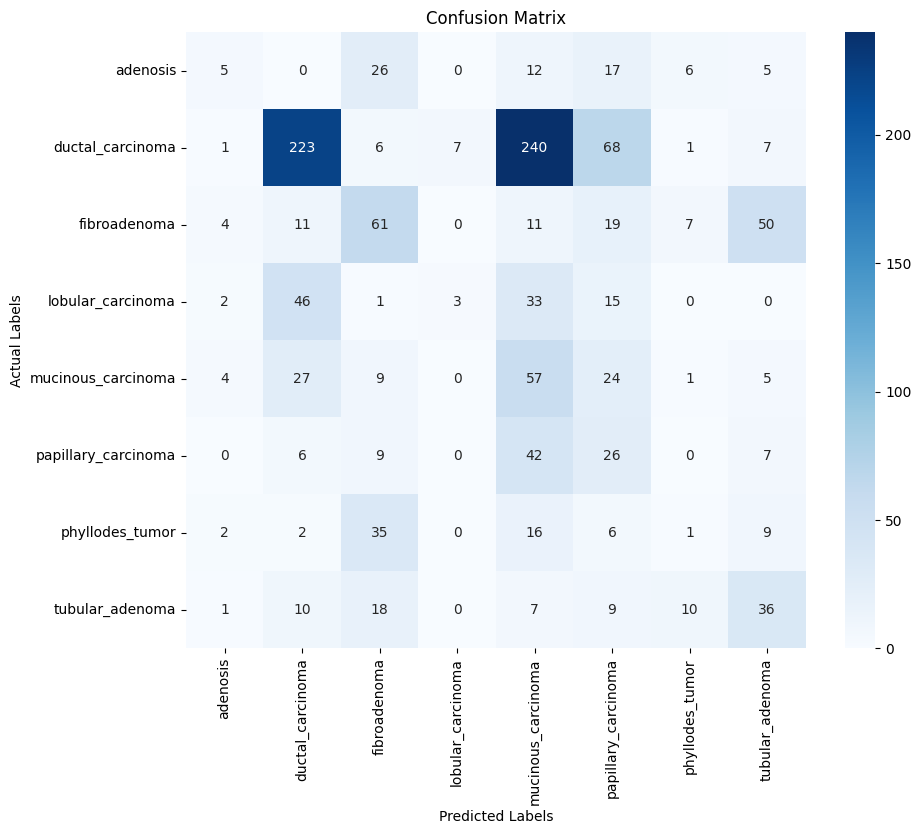

In [ ]:
# of validation
evaluate_model_predictions(model_MC_BMU, X_val_hp_a, y_multiclass_val_hp, y_labels, problem_type='single')

### Base Model Overfitting

In [ ]:
model_MC_BMO = Sequential()
model_MC_BMO.add(Conv2D(80, (3, 3), activation='relu', input_shape=shape_input))
model_MC_BMO.add(Conv2D(80, (3, 3), activation='relu'))
model_MC_BMO.add(MaxPooling2D((3,3)))
model_MC_BMO.add(Conv2D(80, (3, 3), activation='relu'))
model_MC_BMO.add(Conv2D(80, (3, 3), activation='relu'))
model_MC_BMO.add(MaxPooling2D((3,3)))
model_MC_BMO.add(Conv2D(80, (3, 3), activation='relu'))
model_MC_BMO.add(Conv2D(80, (3, 3), activation='relu'))
model_MC_BMO.add(MaxPooling2D((3,3)))
model_MC_BMO.add(Flatten())
model_MC_BMO.add(Dense(124, activation='relu'))

model_MC_BMO.add(Dense(64, activation='relu'))
model_MC_BMO.add(Dense(32, activation='relu'))

model_MC_BMO.add(Dense(8, activation='softmax'))

model_MC_BMO.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])
model_MC_BMO.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 148, 148, 80)        │           2,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 146, 146, 80)        │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 48, 48, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 46, 46, 80)          │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 44, 44, 80)          │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 80)          │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 10, 10, 80)          │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 80)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 720)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 124)                 │          89,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,388 (1.49 MB)

 Trainable params: 390,388 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_MC_BMO = model_MC_BMO.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 100, epochs=50, callbacks=list_callbacks, 
                                  validation_data=[X_val_hp_a, y_multiclass_val_hp], class_weight=class_weights_dict)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - F1Score: 0.0438 - loss: 2.1254 - val_F1Score: 0.0727 - val_loss: 2.0619 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - F1Score: 0.1003 - loss: 2.1090 - val_F1Score: 0.1599 - val_loss: 1.7545 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - F1Score: 0.1437 - loss: 2.0331 - val_F1Score: 0.1046 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - F1Score: 0.1590 - loss: 1.9485 - val_F1Score: 0.2120 - val_loss: 1.7412 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - F1Score: 0.2102 - loss: 1.8683 - val_F1Score: 0.2258 - val_loss: 1.7584 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - F1Score: 0.2067 - loss: 1.8417 - val_F1Score: 0.1536 - val_loss: 1.6683 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - F1Score: 0.1941 - loss: 1.8305 - val_F1Sco

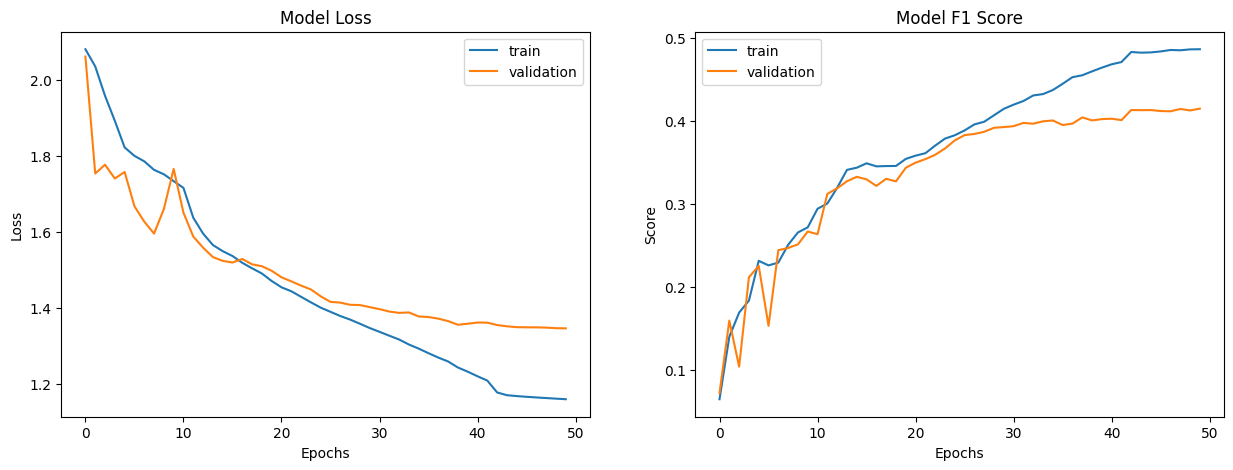

In [ ]:
evaluate_model_train(history_MC_BMO)

The model is clearly overfitting even though it is a bit simpler, we will try to see more complex architectures in the gridsearch to see if we can increase the scores and then see if we reduce the overfitting.

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step
                     precision    recall  f1-score   support

           adenosis       0.43      0.61      0.50        71
   ductal_carcinoma       0.84      0.48      0.61       553
       fibroadenoma       0.41      0.26      0.32       163
  lobular_carcinoma       0.26      0.57      0.35       100
 mucinous_carcinoma       0.45      0.48      0.46       127
papillary_carcinoma       0.24      0.50      0.32        90
    phyllodes_tumor       0.37      0.35      0.36        71
    tubular_adenoma       0.33      0.48      0.39        91

           accuracy                           0.46      1266
          macro avg       0.42      0.47      0.41      1266
       weighted avg       0.57      0.46      0.48      1266



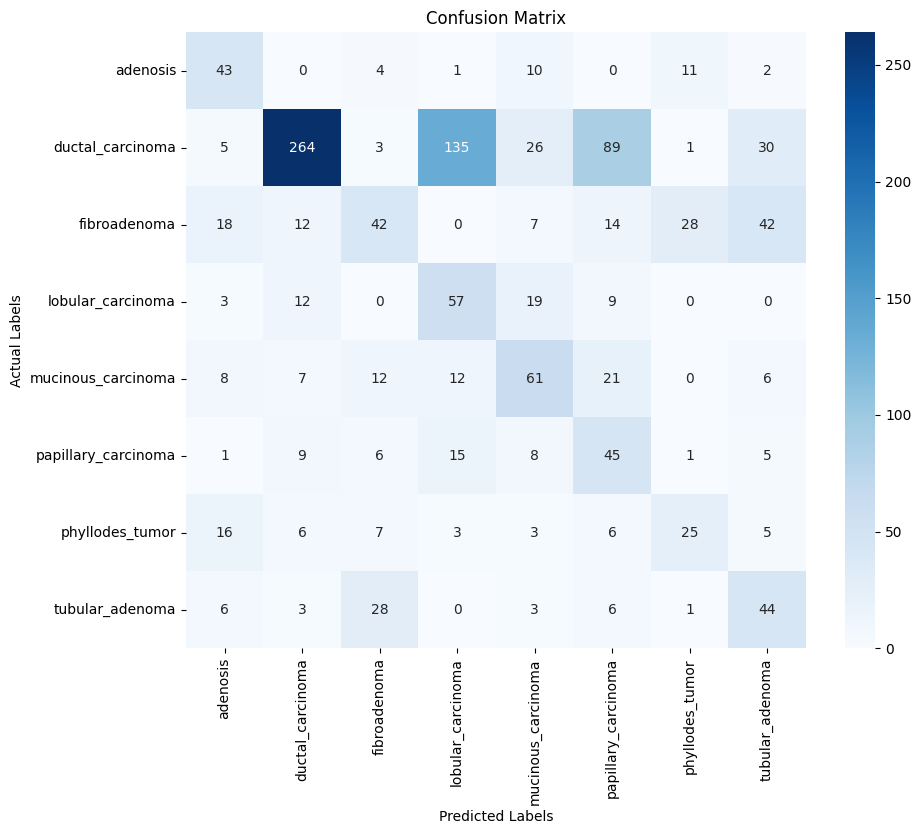

In [ ]:
evaluate_model_predictions(model_MC_BMO, X_val_hp_a, y_multiclass_val_hp, y_labels, problem_type='single')

### Grid search

We will implement a grid search that follows a similar structure to the <a href="https://medium.com/@RaghavPrabhu/cnn-architectures-lenet-alexnet-vgg-googlenet-and-resnet-7c81c017b848">VGG architecture</a>, where we can have groups of convolution layers of the same size following by pooling layers. We will try:
+ Different numbers of conv blocks.
+ Filters of different sizes, strides, padding and number of filters, 
+ Different pooling sizes and strides.
+ Different number of layers and neuros.
+ Different values for dropout.
+ Different regularizes, activation functions and learning rates.


In [ ]:
def build_model_multiclass(hp):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.

    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    
    # Initialize sequential model and start building model.
    model = Sequential()
    # Tune the number of Convolution blocks
    num_conv_blocks = hp.Int("num_conv_blocks", min_value=1, max_value=3)
    regularizer = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', [0.001 , 0.01, 0.0]))
    for i in range(1, num_conv_blocks):
        filter_size = hp.Int('filter_size_' + str(i),min_value=3, max_value=5, step=1)
        strides_conv=hp.Int('stride_conv' + str(i), min_value=1, max_value=2)
        n_filters=hp.Int('n_filters_' + str(i), min_value=32, max_value=80, step=16)
        padding_conv=hp.Choice('padding_conv' + str(i), values=['same', 'valid'])
        # Tune the number of layers in each Convolution block
        conv_block_size = hp.Int("size_conv_block" + str(i), min_value=1, max_value=3)
        for k in range(1, conv_block_size):
            model.add(Conv2D(filters=n_filters,
                         kernel_size=filter_size,
                         strides=strides_conv,
                         padding=padding_conv))
        pooling_size = hp.Int('Pooling_size' + str(i),min_value=3, max_value=5)
        strides_pool=hp.Int('stride_pool' + str(i), min_value=1, max_value=2)
        model.add(MaxPooling2D(pool_size=pooling_size,
                               strides=strides_pool
                               ))
    # Tune the number of hidden layers and units in each.
    model.add(Flatten())
    # The basic for loop for including several layers
    for j in range(1, hp.Int("num_layers", min_value=1, max_value=3)):  
        units = hp.Int("units_" + str(j), min_value=24, max_value=124, step=16)
        model.add(Dense(units=units,
                        activation="relu",
                        kernel_regularizer=regularizer))
        # Dropout following the previous dense layer means that after each layer we would have a dropout
        # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1.
        dropout = hp.Float("dropout_" + str(j), min_value=0, max_value=0.5, step=0.1)
        model.add(Dropout(dropout))

    # Add output layer.
    model.add(Dense(units=8, activation="softmax"))

    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[0.01, 0.001, 0.0001])

    # You can change the optimizer to others (ADPOT is not in keras nor tensorflow)
    hp_optimizer = hp.Choice("Optimizer", values=['Adam', 'Adagrad', 'Adadelta', 'RMSprop'])

    # Define optimizer, loss, and metrics
    model.compile(optimizer=opt_wrapper(hp_optimizer, hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=["F1Score"])
    
    return model

Using hyperband from keras tuner to find the best model.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
tuner_multiclass = kt.Hyperband(build_model_multiclass, # the hypermodel
                     objective='val_loss',  # Our main monitoring metric
                     max_epochs=50,
                     factor=10, # factor which you have seen above
                     directory='.\logs', # directory to save logs
                     project_name='HP_MC_1', # You can name the project itself
                     seed=42) 

Reloading Tuner from /logs\HP_MC_1\tuner0.json


In [ ]:
tuner_multiclass.search(X_train_hp_a, y_multiclass_train_hp, epochs=50, validation_data=[X_val_hp_a, y_multiclass_val_hp], 
                        class_weight=class_weights_dict) 

In [12]:
best_parameters_multiclass= tuner_multiclass.get_best_hyperparameters()[0]
print(best_parameters_multiclass.values)

{'num_conv_blocks': 2, 'type': 'l1', 'reg_value': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'Optimizer': 'Adam', 'filter_size_1': 3, 'stride_conv1': 2, 'n_filters_1': 48, 'padding_conv1': 'valid', 'size_conv_block1': 3, 'Pooling_size1': 4, 'stride_pool1': 1, 'units_1': 104, 'dropout_1': 0.2, 'filter_size_2': 3, 'stride_conv2': 2, 'n_filters_2': 80, 'padding_conv2': 'valid', 'size_conv_block2': 1, 'Pooling_size2': 4, 'stride_pool2': 1, 'units_2': 24, 'dropout_2': 0.1, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


That was the configuration of the best model found, we are not going to analyze the architecture yet since we don’t know if it is good or bad, the important part here is that the best optimizer was Adam so it will be the optimizer that we will use for our next models.

Now we will evaluate it using cross-validation.

In [ ]:
# Define per-fold score containers
f1_per_fold = []
loss_per_fold = []
history_per_fold = []

# Define the Cross Validator
kfold= StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross Validation model evaluation
fold_no = 1

for train, val in kfold.split(X_train_a, np.argmax(y_multiclass_train, axis=1)):

        early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
        LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)

        list_callbacks = [early_stop, LR_ajust]
        
        X_train = X_train_a[train]
        y_train = y_multiclass_train[train]
        X_val = X_train_a[val]
        y_val = y_multiclass_train[val]
        # Define the model architecture

        model= tuner_multiclass.hypermodel.build(best_parameters_multiclass)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model and store the losses per fold during training
        print(y_train.shape)
        history = model.fit(X_train, y_train,
                batch_size=100,
                epochs=50,
                validation_data=[X_val, y_val],
                verbose=1, callbacks=list_callbacks,
                class_weight=class_weights_dict
        )
        history_per_fold.append(history.history['loss'])

        # Generate generalization metrics and evaluate on the k-1 fold
        scores = model.evaluate(X_val, y_val, verbose=1)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        f1_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

        del X_train, y_train, X_val, y_val, model, history

------------------------------------------------------------------------
Training for fold 1 ...
(5694, 8)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - F1Score: 0.1273 - loss: 138.4121 - val_F1Score: 0.0979 - val_loss: 17.8155 - learning_rate: 0.0100
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - F1Score: 0.1705 - loss: 8.6825 - val_F1Score: 0.2517 - val_loss: 1.8876 - learning_rate: 0.0100
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - F1Score: 0.2728 - loss: 1.6189 - val_F1Score: 0.2849 - val_loss: 1.5189 - learning_rate: 0.0100
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - F1Score: 0.3247 - loss: 1.3534 - val_F1Score: 0.3077 - val_loss: 1.5075 - learning_rate: 0.0100
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - F1Score: 0.3643 - loss: 1.2856 - val_F1Score: 0.3443 - val_loss: 1.4546 - learning_rate: 0.0100
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - F1Score: 0.3929 - loss: 1.2186 - val_F1Score: 0.3466 - val_loss: 1.4090 - learning_rate: 

In [15]:
#Provide average scores
print('Score per fold')
for i in range(0, len(f1_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - F1 Score: {round(float(np.mean(f1_per_fold[i])),4)}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> F1 Score: {round(float(np.mean(f1_per_fold)),4)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2925236225128174 - F1 Score: 0.3752
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2277305126190186 - F1 Score: 0.3919
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2595633268356323 - F1 Score: 0.3364
------------------------------------------------------------------------
> Fold 4 - Loss: 1.2130049467086792 - F1 Score: 0.3979
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2096949815750122 - F1 Score: 0.415
------------------------------------------------------------------------
> Fold 6 - Loss: 1.2670954465866089 - F1 Score: 0.3494
------------------------------------------------------------------------
> Fold 7 - Loss: 1.1829222440719604 - F1 Score: 0.4245
------------------------------------------------------------------------
> Fold 8 - Loss: 

The result of this model is like our benchmark (close to the 0.37 in validation data), we will see the results of the pretrained model to decide if it is favorable to continue with this model.

### Pre-Trained Model

Firstly, we will try different architectures and depths of the neural networks (provided by <a href="https://keras.io/api/applications/#usage-examples-for-image-classification-models"> keras</a>); we will use the weights of the ImageNet competition since training a network as big as these is very computationally consuming and we didn’t find weights for a task more in line with ours.

In [ ]:
models_to_test = [ResNet50, InceptionV3, DenseNet121,
 VGG16, Xception,VGG19,ResNet50V2,ResNet101,ResNet101V2,ResNet152V2,InceptionResNetV2,MobileNet,MobileNetV2,DenseNet169,DenseNet201,
 NASNetMobile,NASNetLarge,EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5,
 EfficientNetB6,EfficientNetV2B0]

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

# Logging results
results = {}

# Iterate through models
for model_func in models_to_test:
    print(f"Model {model_func.__name__}")
        
    base_model = model_func(weights='imagenet', include_top=False, input_shape=shape_input)
        
    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Build the complete model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
        ])
        
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])
        
    history_PT_MC = model.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 100, epochs=50,
                              callbacks=list_callbacks, validation_data=[X_val_hp_a, y_multiclass_val_hp], 
                              class_weight=class_weights_dict)
        
    val_f1 = np.max(np.mean(history_PT_MC.history['val_F1Score'], axis=1))
    print(history_PT_MC.history['val_F1Score'])
    print(f"Model {model_func.__name__} achieved {val_f1:.4f} F1-score on validation data.")
    results[model_func.__name__] = val_f1

In [ ]:
results

{'ResNet50': np.float32(0.012481209),
 'InceptionV3': np.float32(0.31713867),
 'DenseNet121': np.float32(0.38757622),
 'VGG16': np.float32(0.31418103),
 'Xception': np.float32(0.33880574),
 'VGG19': np.float32(0.36239463),
 'ResNet50V2': np.float32(0.37621722),
 'ResNet101': np.float32(0.0),
 'ResNet101V2': np.float32(0.3613931),
 'ResNet152V2': np.float32(0.35985112),
 'InceptionResNetV2': np.float32(0.3388791),
 'MobileNet': np.float32(0.38264835),
 'MobileNetV2': np.float32(0.36408764),
 'DenseNet169': np.float32(0.40575033),
 'DenseNet201': np.float32(0.43576694),
 'NASNetMobile': np.float32(0.37554082),
 'NASNetLarge': np.float32(0.28879112),
 'EfficientNetB0': np.float32(0.0),
 'EfficientNetB1': np.float32(0.0),
 'EfficientNetB2': np.float32(0.0),
 'EfficientNetB3': np.float32(0.0),
 'EfficientNetB4': np.float32(0.0),
 'EfficientNetB5': np.float32(0.0),
 'EfficientNetB6': np.float32(0.0),
 'EfficientNetV2B0': np.float32(0.0)}

All of the models obtained a bad result (the maximum was 0.44 F1 score) but are better than our benchmark, so we will continue with the best one that is the DenseNet201 and tune the network parameters.

We will start by creating a simpler model, unfreezing the last conv to finetune it and see the results with more dense layers at the end.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, min_lr = 0.00001)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)),
        Dropout(0.4),
        Dense(512, activation='relu' ,kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)),
        Dropout(0.3),
        Dense(8, activation='softmax')
        ])

# Compile model
model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['F1Score'])

history_PT_MC = model.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 150, epochs=20,
                              callbacks=list_callbacks, validation_data=[X_val_hp_a, y_multiclass_val_hp],
                              class_weight=class_weights_dict)


Epoch 1/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - F1Score: 0.1473 - loss: 84.1516 - val_F1Score: 0.3435 - val_loss: 35.3800 - learning_rate: 0.0010
Epoch 2/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - F1Score: 0.3171 - loss: 30.2618 - val_F1Score: 0.4209 - val_loss: 19.2653 - learning_rate: 0.0010
Epoch 3/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - F1Score: 0.4002 - loss: 17.2477 - val_F1Score: 0.4453 - val_loss: 13.6447 - learning_rate: 0.0010
Epoch 4/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - F1Score: 0.4396 - loss: 12.6904 - val_F1Score: 0.4356 - val_loss: 11.2849 - learning_rate: 0.0010
Epoch 5/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - F1Score: 0.4767 - loss: 10.6484 - val_F1Score: 0.4783 - val_loss: 10.3382 - learning_rate: 0.0010
Epoch 6/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - F1Score: 0.4935 - loss: 10.0707 - val_F1Score: 0.4592 - val_loss: 10.0109 - learning_rate: 0.0010
Epoch 7/18
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - F1Score: 0.5104 - loss: 9.674

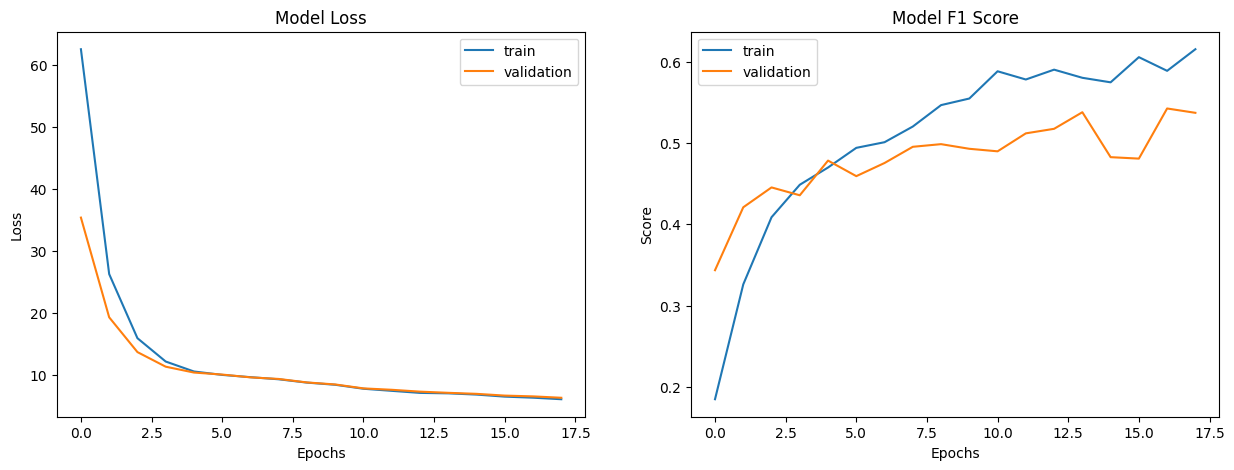

In [ ]:
evaluate_model_train(history_PT_MC)

40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 646ms/step
                     precision    recall  f1-score   support

           adenosis       0.44      0.76      0.56        71
   ductal_carcinoma       0.85      0.54      0.66       553
       fibroadenoma       0.62      0.60      0.61       163
  lobular_carcinoma       0.38      0.77      0.50       100
 mucinous_carcinoma       0.64      0.42      0.50       127
papillary_carcinoma       0.37      0.53      0.44        90
    phyllodes_tumor       0.41      0.39      0.40        71
    tubular_adenoma       0.50      0.81      0.62        91

           accuracy                           0.58      1266
          macro avg       0.53      0.60      0.54      1266
       weighted avg       0.65      0.58      0.59      1266



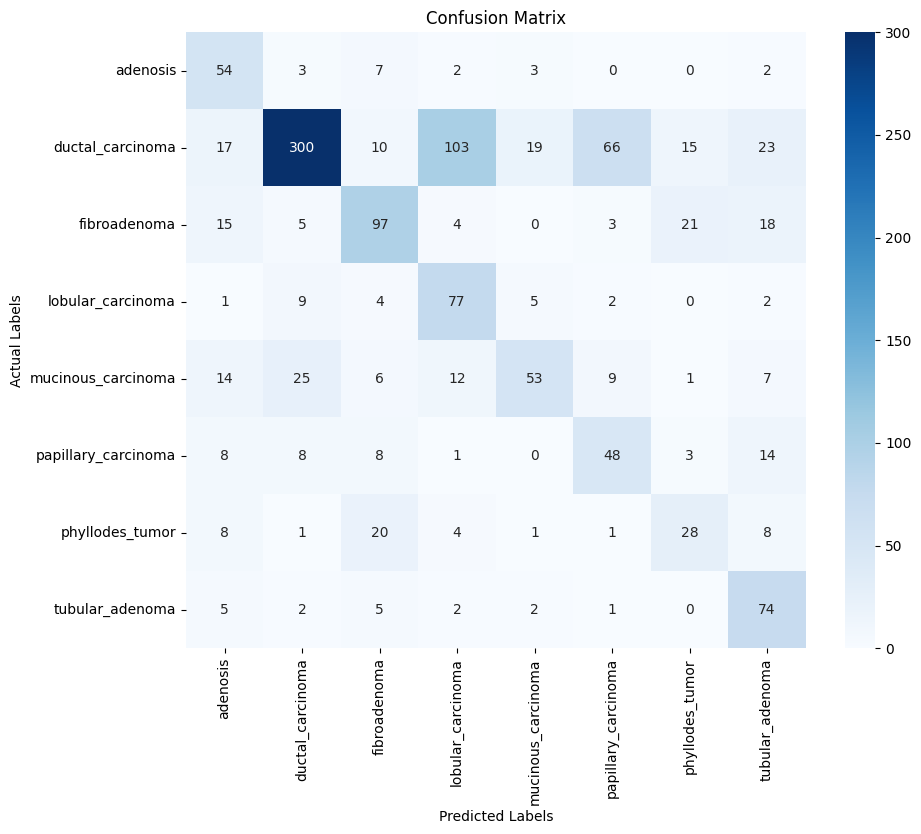

In [ ]:
evaluate_model_predictions(model=model,
                           X_array=X_val_hp_a,
                           y_array_1=y_multiclass_val_hp,
                           y_label_1=y_labels,
                           problem_type='single')

This model achieves better results than the grid search model and than our benchmark (achieving val_loss: 6.2605 and 0.54 F1 score in validation data vs the 0.37 validation F1 score from the benchmark), it has a little bit of overfiting and the loss is still big, so we will try to make further improvements.

Since it's evident that is a problem with the unbalanced nature of our data we will try to use a loss that accounts for that, the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalFocalCrossentropy"> CategoricalFocalCrossentropy</a> (“Use this crossentropy loss function when there are two or more label classes and if you want to handle class imbalance without using class_weights), with the same model architecture and class weight.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, min_lr = 0.00001)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)),
        Dropout(0.4),
        Dense(512, activation='relu' ,kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)),
        Dropout(0.3),
        Dense(8, activation='softmax')
        ])

# Compile model
model.compile(optimizer= Adam(0.001), loss=CategoricalFocalCrossentropy(), metrics=['F1Score'])

history_PT_MC = model.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 150, epochs=20,
                              callbacks=list_callbacks, validation_data=[X_val_hp_a, y_multiclass_val_hp],
                              class_weight=class_weights_dict
                          )

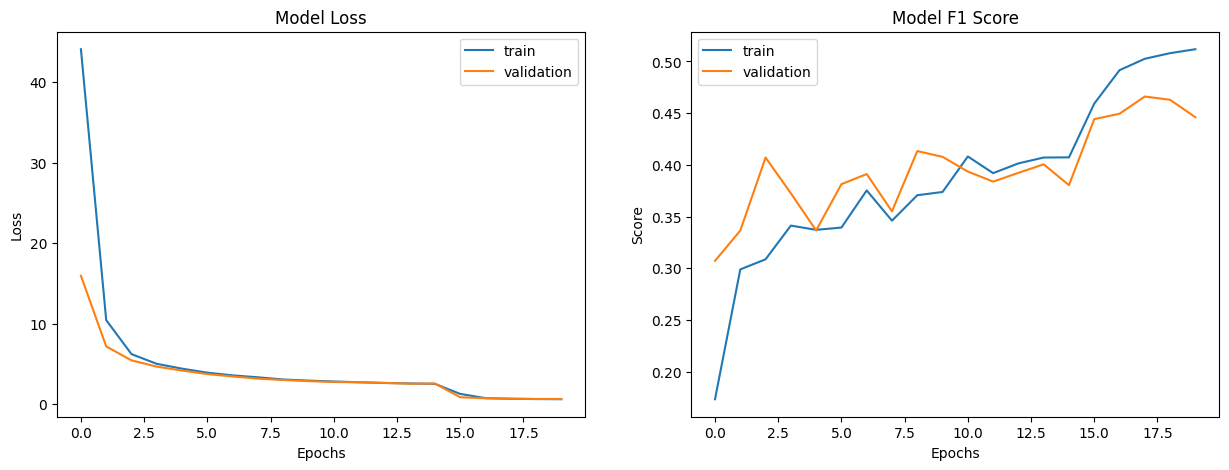

In [ ]:
evaluate_model_train(history_PT_MC)

40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 618ms/step
                     precision    recall  f1-score   support

           adenosis       0.42      0.76      0.54        71
   ductal_carcinoma       0.81      0.49      0.61       553
       fibroadenoma       0.40      0.35      0.37       163
  lobular_carcinoma       0.32      0.60      0.42       100
 mucinous_carcinoma       0.31      0.41      0.35       127
papillary_carcinoma       0.33      0.37      0.35        90
    phyllodes_tumor       0.33      0.38      0.36        71
    tubular_adenoma       0.49      0.68      0.57        91

           accuracy                           0.49      1266
          macro avg       0.43      0.50      0.45      1266
       weighted avg       0.56      0.49      0.50      1266



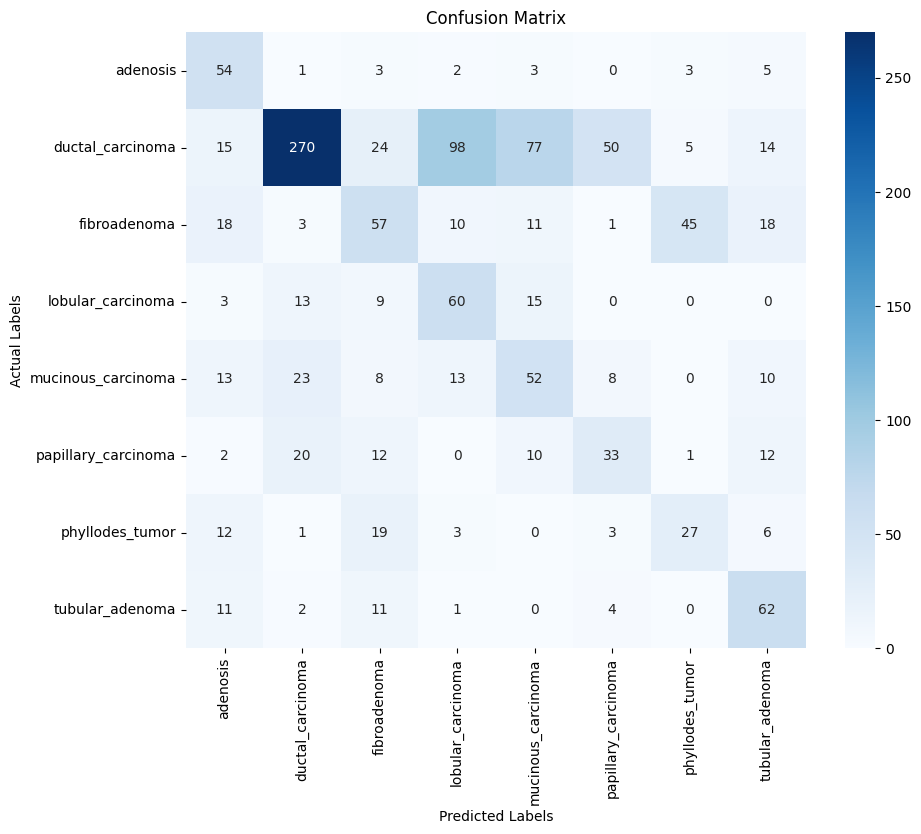

In [ ]:
evaluate_model_predictions(model=model,
                           X_array=X_val_hp_a,
                           y_array_1=y_multiclass_val_hp,
                           y_label_1=y_labels,
                           problem_type='single')

The results decreased a lot, achieving 0.45 F1 score in validation.

We will try the same loss but with no class weight.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, min_lr = 0.00001)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)),
        Dropout(0.4),
        Dense(512, activation='relu' ,kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)),
        Dropout(0.3),
        Dense(8, activation='softmax')
        ])

# Compile model
model.compile(optimizer= Adam(0.001), loss=CategoricalFocalCrossentropy(), metrics=['F1Score'])

history_PT_MC = model.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 150, epochs=20,
                              callbacks=list_callbacks, validation_data=[X_val_hp_a, y_multiclass_val_hp]
                          )


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - F1Score: 0.0927 - loss: 65.9971 - val_F1Score: 0.0953 - val_loss: 11.7891 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - F1Score: 0.1239 - loss: 9.6982 - val_F1Score: 0.2430 - val_loss: 5.6247 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - F1Score: 0.2205 - loss: 5.1052 - val_F1Score: 0.2312 - val_loss: 3.9737 - learning_rate: 0.0010
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - F1Score: 0.2515 - loss: 3.7674 - val_F1Score: 0.3039 - val_loss: 3.2211 - learning_rate: 0.0010
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - F1Score: 0.2685 - loss: 3.1421 - val_F1Score: 0.2734 - val_loss: 2.8653 - learning_rate: 0.0010
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - F1Score: 0.2878 - loss: 2.8246 - val_F1Score: 0.2534 - val_loss: 2.6738 - learning_rate: 0.0010
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - F1Score: 0.2866 - loss: 2.6382 - val_F1

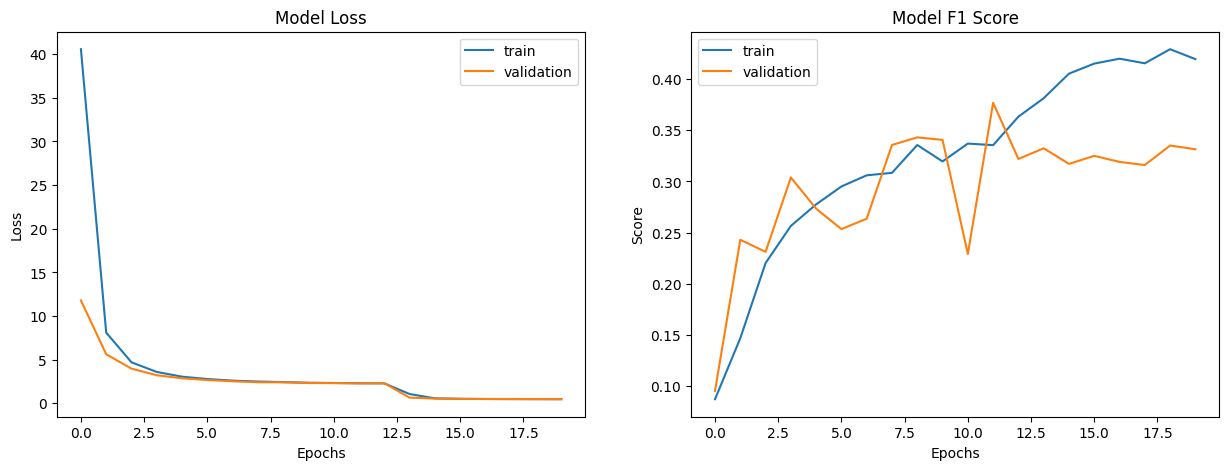

In [ ]:
evaluate_model_train(history_PT_MC)

40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 638ms/step
                     precision    recall  f1-score   support

           adenosis       0.62      0.28      0.39        71
   ductal_carcinoma       0.62      0.93      0.74       553
       fibroadenoma       0.47      0.67      0.55       163
  lobular_carcinoma       1.00      0.04      0.08       100
 mucinous_carcinoma       0.36      0.13      0.19       127
papillary_carcinoma       0.36      0.10      0.16        90
    phyllodes_tumor       0.00      0.00      0.00        71
    tubular_adenoma       0.54      0.57      0.55        91

           accuracy                           0.57      1266
          macro avg       0.50      0.34      0.33      1266
       weighted avg       0.54      0.57      0.49      1266



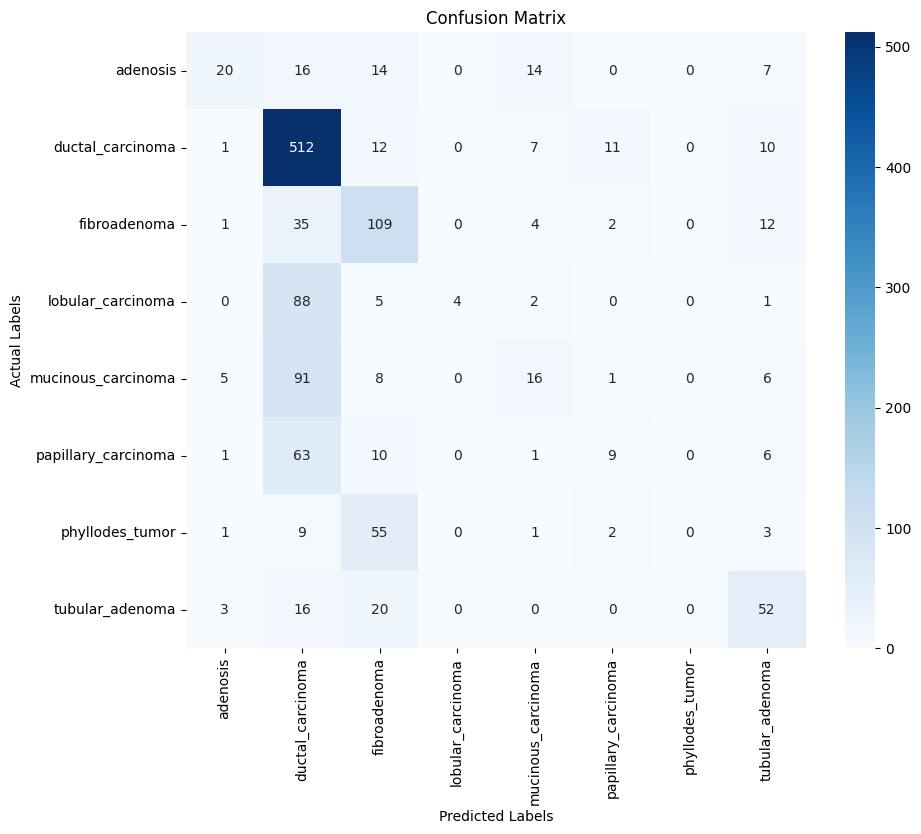

In [ ]:
evaluate_model_predictions(model=model,
                           X_array=X_val_hp_a,
                           y_array_1=y_multiclass_val_hp,
                           y_label_1=y_labels,
                           problem_type='single')

The results are even worse (0.33 F1 score in validation) with no class weight and loss being categorical focal cross entropy.

We will now try the "normal" loss with the class weights, increasing the dense network size and reducing the number of epochs to have better results.

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1)
list_callbacks = [early_stop, LR_ajust]


In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=shape_input)



# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(2048, activation='relu', kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005)),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005) ),
        Dropout(0.4),
        Dense(8, activation='softmax')
        ])

# Compile model
model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['F1Score'])

history_PT_MC = model.fit(X_train_hp_a, y_multiclass_train_hp, batch_size= 100, epochs=20,
                              callbacks=list_callbacks, validation_data=[X_val_hp_a, y_multiclass_val_hp],
                              class_weight=class_weights_dict)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - F1Score: 0.1594 - loss: 150.0191 - val_F1Score: 0.3504 - val_loss: 52.2468 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - F1Score: 0.3219 - loss: 43.2304 - val_F1Score: 0.3519 - val_loss: 26.6688 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - F1Score: 0.3775 - loss: 24.0456 - val_F1Score: 0.4133 - val_loss: 19.4546 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - F1Score: 0.3911 - loss: 18.7682 - val_F1Score: 0.4709 - val_loss: 17.0994 - learning_rate: 0.0010
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - F1Score: 0.4287 - loss: 16.7290 - val_F1Score: 0.4226 - val_loss: 15.4622 - learning_rate: 0.0010
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - F1Score: 0.4245 - loss: 15.1806 - val_F1Score: 0.3917 - val_loss: 14.4232 - learning_rate: 0.0010
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━

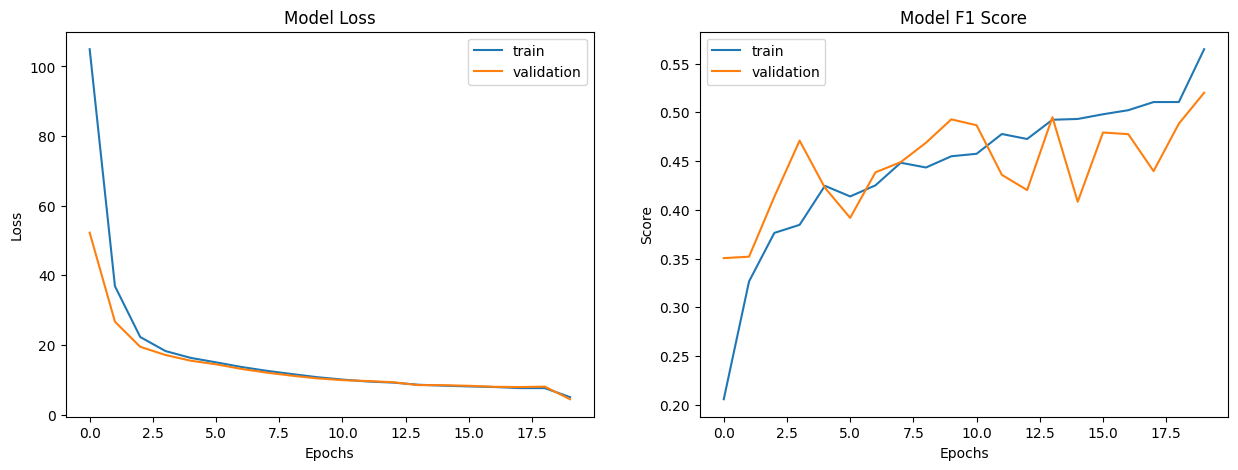

In [ ]:
evaluate_model_train(history_PT_MC)

40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 731ms/step
                     precision    recall  f1-score   support

           adenosis       0.47      0.77      0.59        71
   ductal_carcinoma       0.84      0.53      0.65       553
       fibroadenoma       0.56      0.50      0.53       163
  lobular_carcinoma       0.38      0.76      0.51       100
 mucinous_carcinoma       0.49      0.39      0.43       127
papillary_carcinoma       0.33      0.51      0.40        90
    phyllodes_tumor       0.41      0.51      0.46        71
    tubular_adenoma       0.51      0.74      0.60        91

           accuracy                           0.56      1266
          macro avg       0.50      0.59      0.52      1266
       weighted avg       0.63      0.56      0.57      1266



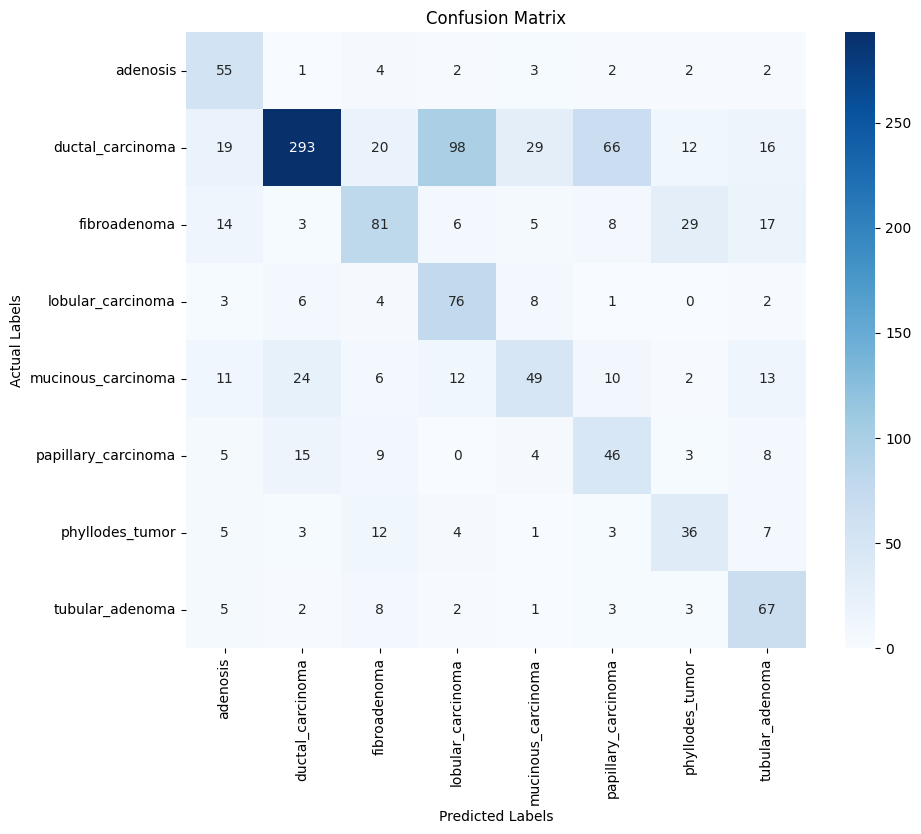

In [ ]:
evaluate_model_predictions(model, X_val_hp_a, y_multiclass_val_hp, y_labels, problem_type='single')

With the new configuration, the F1 score in the validation is 0.52 (a little less than the best one that was 0.54), but now with a lower loss (4.3 in validation vs the 6.2 in the simpler model), because of that we will use this last model.

### Best Model

We know the best model is the:

```plaintext
DenseNet201(weights='imagenet', 
            include_top=False, 
            input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
best_model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(2048, activation='relu', 
              kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005)),
        Dropout(0.5),
        Dense(1024, activation='relu', 
              kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005) ),
        Dropout(0.4),
        Dense(8, activation='softmax')
        ])

best_model.compile(optimizer= Adam(0.001), 
                    loss='categorical_crossentropy',
                    metrics=['F1Score'])
```
Now we will test some variants of the implementation.

#### Using the Image Data Generator

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
best_model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(2048, activation='relu', kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005)),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005) ),
        Dropout(0.4),
        Dense(8, activation='softmax')
        ])

# Compile
best_model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['F1Score'])


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
datagen = ImageDataGenerator(rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

datagen.fit(X_train_hp_a)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_mc = best_model.fit(datagen.flow(X_train_hp_a, y_multiclass_train_hp, batch_size=100),
                        validation_data=[X_val_hp_a, y_multiclass_val_hp],epochs=50, 
                        callbacks  = list_callbacks, class_weight=class_weights_dict)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - F1Score: 0.1517 - loss: 145.4886 - val_F1Score: 0.1746 - val_loss: 41.9001 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 680ms/step - F1Score: 0.1998 - loss: 33.5340 - val_F1Score: 0.2450 - val_loss: 19.5865 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 685ms/step - F1Score: 0.2328 - loss: 18.1847 - val_F1Score: 0.2784 - val_loss: 15.6457 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 724ms/step - F1Score: 0.2471 - loss: 15.1386 - val_F1Score: 0.2383 - val_loss: 13.6474 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 722ms/step - F1Score: 0.2370 - loss: 13.4435 - val_F1Score: 0.2390 - val_loss: 11.8793 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 716ms/step - F1Score: 0.2778 - loss: 11.5203 - val_F1Score: 0.3402 - val_loss: 10.7937 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 670ms/step - F1Score: 0.2666 - loss: 10.5

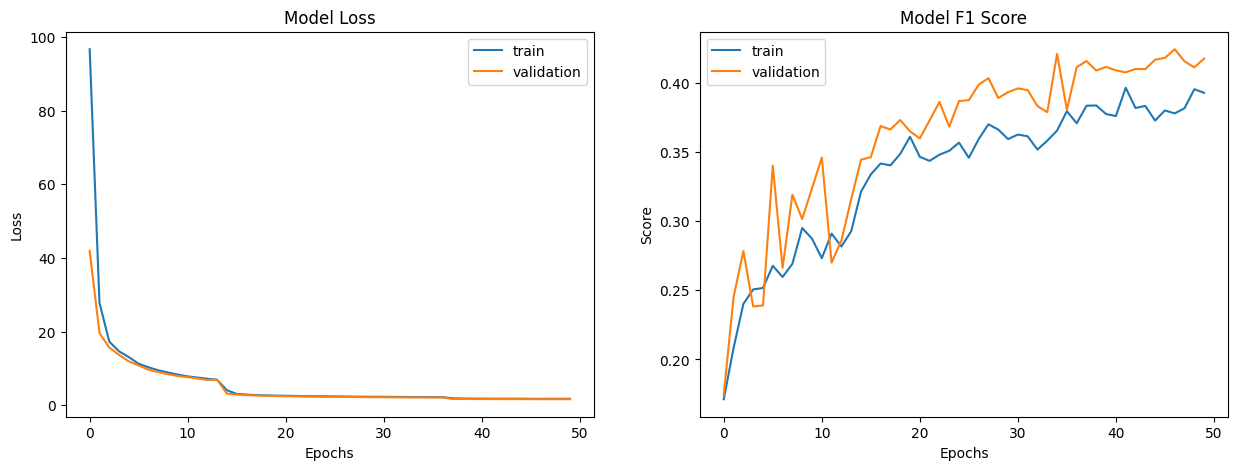

In [ ]:
evaluate_model_train(history_mc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 449ms/step
                     precision    recall  f1-score   support

           adenosis       0.46      0.54      0.49        71
   ductal_carcinoma       0.68      0.93      0.79       553
       fibroadenoma       0.51      0.70      0.59       163
  lobular_carcinoma       0.78      0.18      0.29       100
 mucinous_carcinoma       0.46      0.28      0.34       127
papillary_carcinoma       0.45      0.11      0.18        90
    phyllodes_tumor       0.71      0.07      0.13        71
    tubular_adenoma       0.60      0.47      0.53        91

           accuracy                           0.62      1266
          macro avg       0.58      0.41      0.42      1266
       weighted avg       0.61      0.62      0.56      1266



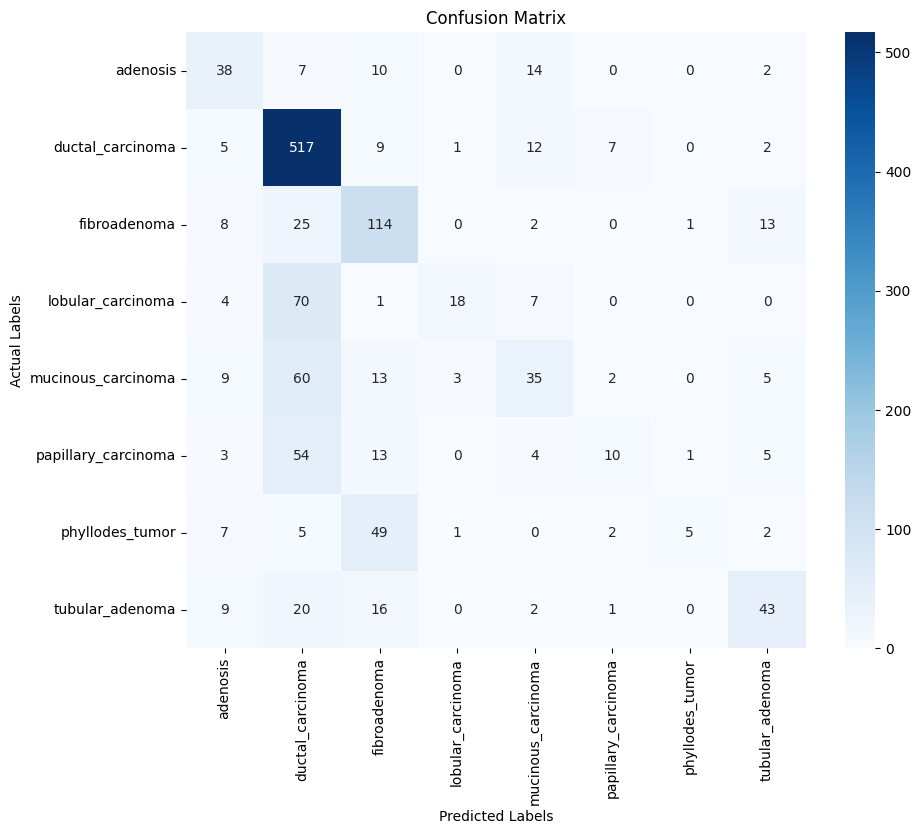

In [ ]:
evaluate_model_predictions(best_model, X_val_hp_a, y_multiclass_val_hp, y_labels, problem_type='single')

Using image data generator didn’t improve the results, now the model predicts only the majority class, we tried to see if it can generalize better but as we know the image data generator doesn’t change the class distribution. Because the F1 score for validation is 0.42, we will discard the use of it. 

### Best Multiclass model with Magnitude

We will try to implement our best model, but now in the dense layer part it will receive the feature maps extracted from the images and, additionally, the magnitude of the images.

In [ ]:
# Model Advanced

# Inputs
input_tensor = Input(shape=shape_input, name='image')
input_magnitude = Input(shape=shape_mag, name='magnitude')


# base model
PT_model = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)

for layer in PT_model.layers[:-5]:
    layer.trainable = False

# Flaten
PT_output = PT_model.output
flat = Flatten(name='Flat')(PT_output)
flat = concatenate([flat, input_magnitude], axis=1, name='Flat_MC')

# Dense
MC_dense = Dropout(0.5, name='MC_dropout0')(flat)
MC_dense = Dense(2048, activation='relu', kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005), name='MC_Dense1')(MC_dense)
MC_dense = Dropout(0.5, name='MC_dropout1')(MC_dense)
MC_dense = Dense(1024, activation='relu', kernel_regularizer=L1L2(l1 = 0.0005, l2 = 0.0005), name='MC_Dense2' )(MC_dense)
MC_dense = Dropout(0.4, name='MC_dropout2')(MC_dense)
MC_output = Dense(8, activation='softmax', name='MC_output')(MC_dense)

# build de model
model_MC_Adv = Model([input_tensor,input_magnitude], MC_output)

model_MC_Adv.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['F1Score'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
x_data = {'image' : X_train_hp_a,
            'magnitude' : Mag_train_hp}

val_data_dic_in = {'image' : X_val_hp_a,
                    'magnitude' : Mag_val_hp}

In [ ]:
sample_weight_train_hp_MC = np.array(list(map(class_weights_dict.get, np.argmax(y_multiclass_train_hp, axis=1))))
sample_weight_train_hp_MC[:10]

array([0.28647493, 0.28647493, 0.28647493, 1.57927316, 0.97497535,
       0.28647493, 0.28647493, 1.76540179, 0.97497535, 2.18239514])

In [ ]:
history_MC_adv = model_MC_Adv.fit(x_data,
                          y_multiclass_train_hp,
                          batch_size= 100,
                          epochs=50,
                          callbacks=list_callbacks,
                          validation_data=[val_data_dic_in, y_multiclass_val_hp],
                          sample_weight=sample_weight_train_hp_MC
                          )

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - F1Score: 0.1600 - loss: 148.2193 - val_F1Score: 0.4180 - val_loss: 49.8482 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - F1Score: 0.3148 - loss: 41.3721 - val_F1Score: 0.3640 - val_loss: 25.2393 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - F1Score: 0.3686 - loss: 23.1621 - val_F1Score: 0.3886 - val_loss: 19.1568 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - F1Score: 0.3879 - loss: 18.5858 - val_F1Score: 0.4476 - val_loss: 16.9356 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step - F1Score: 0.4049 - loss: 16.3187 - val_F1Score: 0.4024 - val_loss: 15.6456 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - F1Score: 0.4392 - loss: 14.8672 - val_F1Score: 0.4788 - val_loss: 13.6698 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - F1Score: 0.4516 - loss: 13.17

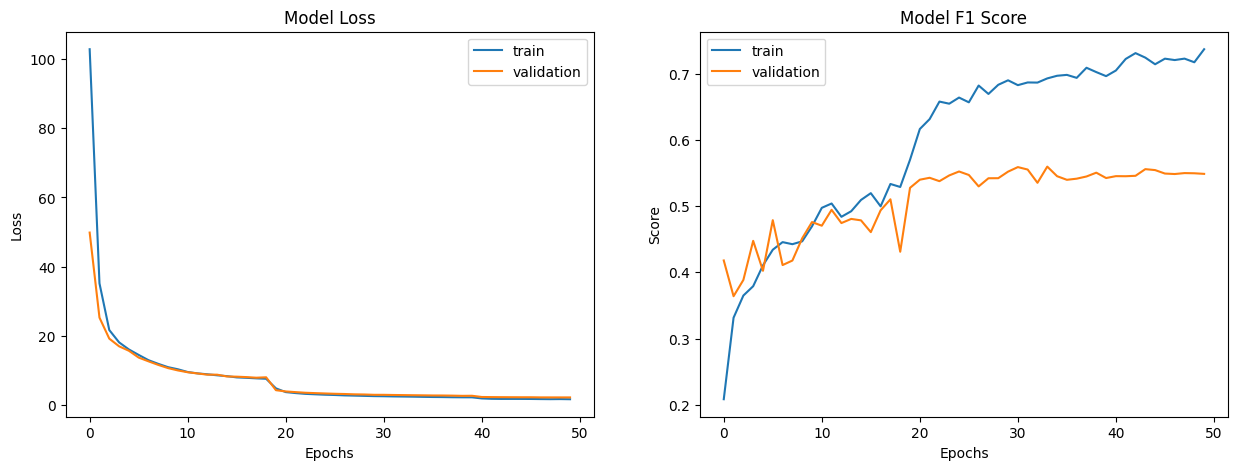

In [ ]:
evaluate_model_train(history_MC_adv)

40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step
                     precision    recall  f1-score   support

           adenosis       0.56      0.68      0.61        71
   ductal_carcinoma       0.84      0.60      0.70       553
       fibroadenoma       0.55      0.63      0.58       163
  lobular_carcinoma       0.44      0.71      0.54       100
 mucinous_carcinoma       0.47      0.53      0.50       127
papillary_carcinoma       0.38      0.54      0.45        90
    phyllodes_tumor       0.42      0.35      0.38        71
    tubular_adenoma       0.57      0.68      0.62        91

           accuracy                           0.60      1266
          macro avg       0.53      0.59      0.55      1266
       weighted avg       0.64      0.60      0.61      1266



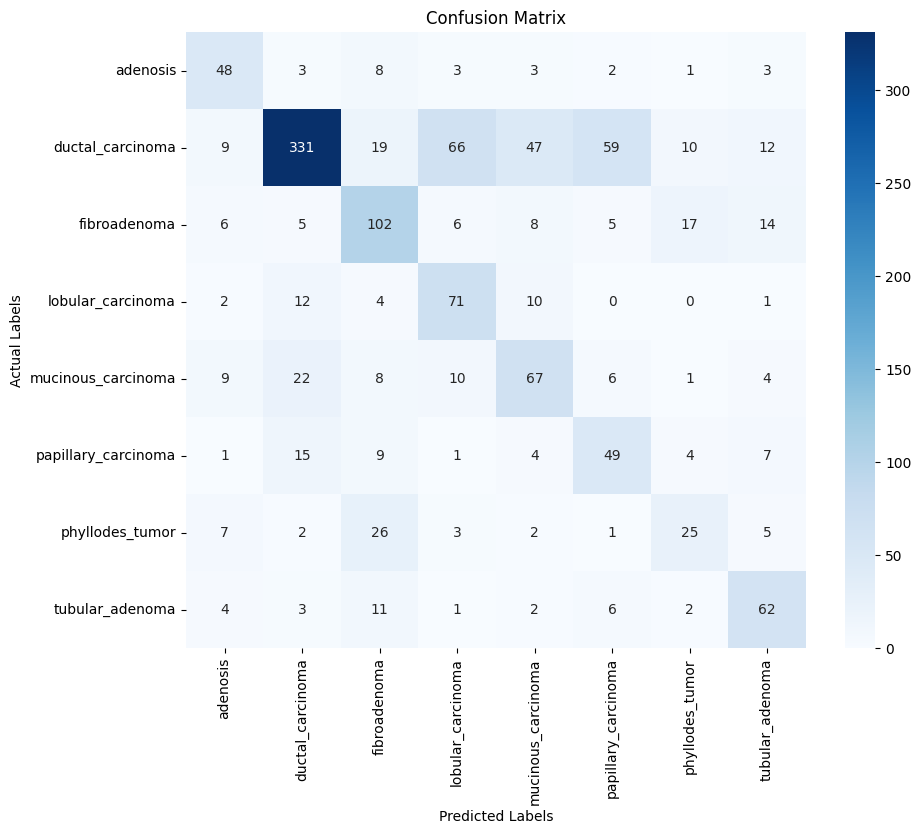

In [ ]:
evaluate_model_predictions(model=model_MC_Adv,
                           X_array=val_data_dic_in,
                           y_array_1=y_multiclass_val_hp,
                           y_label_1=y_labels,
                           problem_type='single')

This is our best model so far, achieving a 0.55 F1 score in validation (very similar to the previous best of 0.53), but with a loss in validation of 2.14 (vs the previous 4.3 loss in validation), being the first model to achieve a F1 score so high in validation with such a small loss.

## Final Evaluation on Test

In [ ]:
X_test_data = {"image": X_test_a,
               "magnitude": Mag_test}

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step
                     precision    recall  f1-score   support

           adenosis       0.53      0.70      0.60        89
   ductal_carcinoma       0.84      0.64      0.72       691
       fibroadenoma       0.58      0.64      0.61       203
  lobular_carcinoma       0.40      0.65      0.49       125
 mucinous_carcinoma       0.57      0.60      0.58       158
papillary_carcinoma       0.43      0.56      0.49       112
    phyllodes_tumor       0.47      0.42      0.45        90
    tubular_adenoma       0.65      0.68      0.66       114

           accuracy                           0.62      1582
          macro avg       0.56      0.61      0.58      1582
       weighted avg       0.66      0.62      0.63      1582



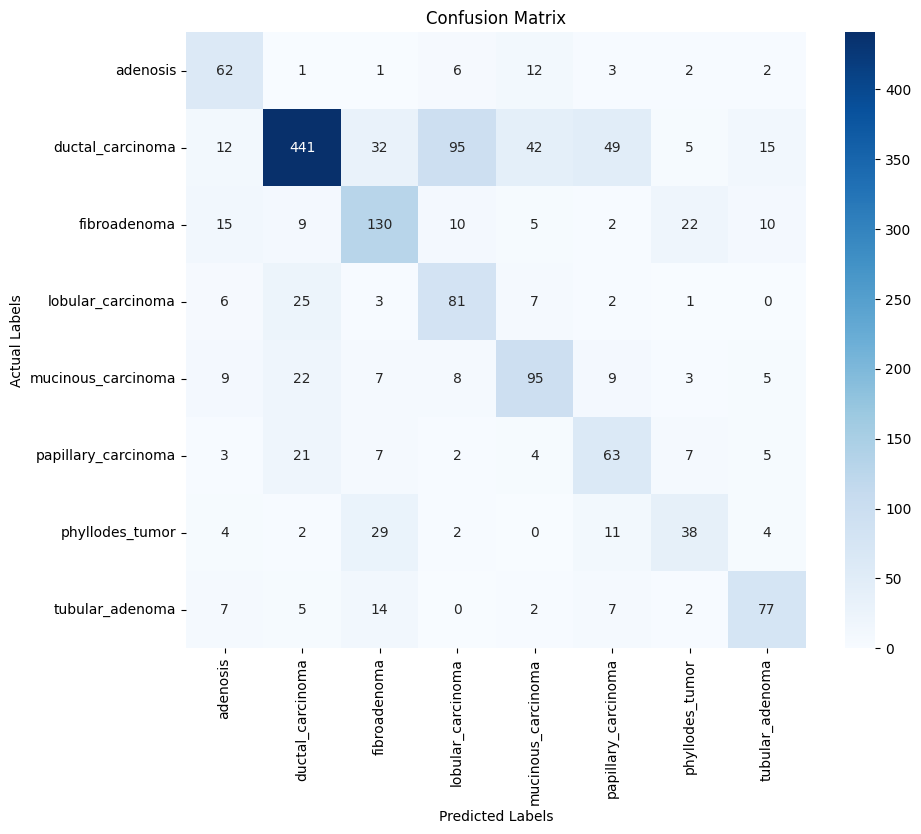

In [ ]:
evaluate_model_predictions(model_MC_Adv, X_test_data, y_multiclass_test, y_labels, problem_type='single' )

Now after testing our best model on the test set, we confirm that the benchmark was passed (0.38 F1 score on test set), achieving a F1 score of 0.58, and a weighted one of 0.63. 

Obviously the weighted average is slightly higher, because, as expected, the class our model finds easiest to classify is the majority class 
(ductal_carcinoma), which inflates the weighted average when comparing to the macro average as it is ~3.5 times more common than the second most common cancer type (fibroadenoma). 

Interestingly, the minority class (Adenosis) is one the classes with the highest F1 score, this is likely due to this cancer type presenting unique and distinct characteristics. On the other hand, the second least common class (phyllodes_tumor) achieves the lowest F1 score across all classes, despite being essentially as common as the class mentioned previously.

## Next Step
Go to the Experiment notebooks (if you already saw the Binary one) to see the process of trying to improve our best models.